In [1]:
import dgl
import torch
import numpy as np
import os
import random
import pandas
from utils import *
from models.detector import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

def set_seed(seed=3407):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True


class BWGNN_DB(nn.Module):
    def __init__(self, in_feats=400, h_feats=32, num_classes=2, num_layers=2, mlp_layers=2, dropout_rate=0, **kwargs):
        super().__init__()
        self.thetas = calculate_theta(d=num_layers)
        self.conv = []
        for i in range(len(self.thetas)):
            self.conv.append(PolyConv(self.thetas[i]))
        self.linear = nn.Linear(in_feats, h_feats)
        self.linear2 = nn.Linear(h_feats, h_feats)
        self.mlp = MLP(h_feats*len(self.conv), h_feats, num_classes, mlp_layers, dropout_rate)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None

    def forward(self, graph):
        in_feat = graph.ndata['feature']
        h = self.linear(in_feat)
        h = self.act(h)
        h = self.linear2(h)
        h = self.act(h)
        h_final = torch.zeros([len(in_feat), 0], device=h.device)

        for conv in self.conv:
            h0 = conv(graph, h)
            h_final = torch.cat([h_final, h0], -1)
        if self.dropout:
            h_final = self.dropout(h_final)
        h = self.mlp(h_final, False)

        return h, h_final
    
class BWGNNDetector(BaseDetector):
    def __init__(self, train_config, model_config, data):
        super().__init__(train_config, model_config, data)
        model_config['in_feats'] = self.data.graph.ndata['feature'].shape[1]
        self.model = BWGNN_DB(**model_config).to(train_config['device'])

    def train(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.model_config['lr'])
        train_labels, val_labels, test_labels = self.labels[self.train_mask], \
                                                self.labels[self.val_mask], self.labels[self.test_mask]
        for e in range(self.train_config['epochs']):
            self.model.train()
            logits, hiddens = self.model(self.source_graph)
            loss = F.cross_entropy(logits[self.train_mask], train_labels,
                                   weight=torch.tensor([1., self.weight], device=self.labels.device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if self.model_config['drop_rate'] > 0:
                self.model.eval()
                logits = self.model(self.source_graph)
            probs = logits.softmax(1)[:,1]
            val_score = self.eval(val_labels, probs[self.val_mask])
            if val_score[self.train_config['metric']] > self.best_score:
                self.patience_knt = 0
                self.best_score = val_score[self.train_config['metric']]
                test_score = self.eval(test_labels, probs[self.test_mask])

            else:
                self.patience_knt += 1
                if self.patience_knt > self.train_config['patience']:
                    break
        return test_score, hiddens
    
class GHRNDetector(BaseDetector):
    def __init__(self, train_config, model_config, data):
        super().__init__(train_config, model_config, data)
        model_config['in_feats'] = self.data.graph.ndata['feature'].shape[1]
        self.model = BWGNN_DB(**model_config).to(train_config['device'])

    def random_walk_update(self, delete_ratio, adj_type):
        graph = self.source_graph
        edge_weight = torch.ones(graph.num_edges()).to(self.train_config['device'])
        if adj_type == 'sym':
            norm = dgl.nn.pytorch.conv.EdgeWeightNorm(norm='both')
        else:
            norm = dgl.nn.pytorch.conv.EdgeWeightNorm(norm='left')
        graph.edata['w'] = norm(graph, edge_weight)
        # functions
        aggregate_fn = fn.u_mul_e('h', 'w', 'm')
        reduce_fn = fn.sum(msg='m', out='ay')

        graph.ndata['h'] = graph.ndata['feature']
        graph.update_all(aggregate_fn, reduce_fn)
        graph.ndata['ly'] = graph.ndata['feature'] - graph.ndata['ay']
        # graph.ndata['lyyl'] = torch.matmul(graph.ndata['ly'], graph.ndata['ly'].T)
        graph.apply_edges(self.inner_product_black)
        # graph.apply_edges(inner_product_white)
        black = graph.edata['inner_black']
        # white = graph.edata['inner_white']
        # delete
        threshold = int(delete_ratio * graph.num_edges())
        edge_to_move = set(black.sort()[1][:threshold].tolist())
        # edge_to_protect = set(white.sort()[1][-threshold:].tolist())
        edge_to_protect = set()
        graph_new = dgl.remove_edges(graph, list(edge_to_move.difference(edge_to_protect)))
        return graph_new

    def inner_product_black(self, edges):
        # if edges.src['ly'].shape[0] > 10000000
        edges_num = edges.src['ly'].shape[0]
        print(edges.src['ly'].shape, edges.dst['ly'].shape)
        inner_black = torch.zeros([edges_num], device=edges.src['ly'].device)
        step = 30000000
        idx = 0
        while idx < edges_num:
            st = idx
            idx += step
            ed = idx if idx < edges_num else edges_num
            inner_black[st:ed] = (edges.src['ly'][st:ed] * edges.dst['ly'][st:ed]).sum(1).detach().clone()
            # f1 = features[edges.indices()[0,st:ed]]
            # f2 = features[edges.indices()[1,st:ed]]
        # inner_black = (edges.src['ly'] * edges.dst['ly']).sum(axis=1)
        return {'inner_black': inner_black}

    def train(self):
        del_ratio = 0.015 if 'del_ratio' not in self.model_config else self.model_config['del_ratio']
        adj_type = 'sym' if 'adj_type' not in self.model_config else self.model_config['adj_type']
        if del_ratio != 0.:
            graph = self.random_walk_update(del_ratio, adj_type)
            graph = dgl.add_self_loop(dgl.remove_self_loop(graph))

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.model_config['lr'])
        train_labels, val_labels, test_labels = self.labels[self.train_mask], \
                                                self.labels[self.val_mask], self.labels[self.test_mask]
        for e in range(self.train_config['epochs']):
            self.model.train()
            logits, hiddens = self.model(graph)
            loss = F.cross_entropy(logits[self.train_mask], train_labels,
                                   weight=torch.tensor([1., self.weight], device=self.labels.device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            probs = logits.softmax(1)[:, 1]
            val_score = self.eval(val_labels, probs[self.val_mask])
            if val_score[self.train_config['metric']] > self.best_score:
                self.patience_knt = 0
                self.best_score = val_score[self.train_config['metric']]
                test_score = self.eval(test_labels, probs[self.test_mask])
            else:
                self.patience_knt += 1
                if self.patience_knt > self.train_config['patience']:
                    break
        return test_score, hiddens

Matplotlib created a temporary cache directory at /tmp/matplotlib-8nsm89ci because the default path (/homes/yliumh/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
seed_list = list(range(3500, 10000, 10))


train_config = {
    'device': 'cuda',
    'epochs': 200,
    'patience': 50,
    'metric': 'AUPRC',
    'seed': 3500,
    'inductive': False,
}

tsne = TSNE(n_components=2, random_state=42, verbose=1, n_jobs=32)

data = Dataset('tfinance')
data.split(False,0)

In [ ]:
gin = GIN_noparam()
feat = gin(data.graph)
X_2d = tsne.fit_transform(feat)
data.graph.ndata['feature'] = torch.tensor(X_2d)
# xgb_detector1 = XGBoostDetector(train_config, {}, data1)
set_seed()

RF_detector1 = RFDetector(train_config, {}, data)
mlp_detector1 = BaseGNNDetector(train_config, {'model': 'MLP', 'lr': 0.01, 'drop_rate':0}, data)
mlp_detector1.train()
RF_detector1.train()

h = .1
x_min, x_max = X_2d[:, 0].min() - .5, X_2d[:, 0].max() + .5
y_min, y_max = X_2d[:, 1].min() - .5, X_2d[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z_MLP = (mlp_detector1.model.forward(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float().cuda(), is_graph=False).softmax(1).cpu().detach().numpy()[:,1]).reshape(xx.shape)
Z_RF =RF_detector1.model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

In [ ]:
Z_RF =RF_detector1.model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1].reshape(xx.shape)

In [ ]:
data2 = Dataset('tolokers')
data2.split(False,1)

# detector2 = BWGNNDetector(train_config,{ 'lr': 0.01, 'drop_rate':0}, data2)
detector2 = GHRNDetector(train_config,{ 'lr': 0.01, 'drop_rate':0}, data2)
score2, hiddens2 = detector2.train()

feat2 = hiddens2.cpu().detach().numpy()
X_2d2 = tsne.fit_transform(feat2)
data2.graph.ndata['feature'] = torch.tensor(X_2d2)
xgb_detector2 = XGBoostDetector(train_config, {}, data2)
mlp_detector2 = BaseGNNDetector(train_config, {'model': 'MLP', 'lr': 0.01, 'drop_rate':0}, data2)
mlp_detector2.train()
xgb_detector2.train()

x_min2, x_max2 = X_2d2[:, 0].min() - .5, X_2d2[:, 0].max() + .5
y_min2, y_max2 = X_2d2[:, 1].min() - .5, X_2d2[:, 1].max() + .5
xx2, yy2 = np.meshgrid(np.arange(x_min2, x_max2, h), np.arange(y_min2, y_max2, h))

Z_BWGNN_MLP = (mlp_detector2.model.forward(torch.tensor(np.c_[xx2.ravel(), yy2.ravel()]).float().cuda(), is_graph=False).softmax(1).cpu().detach().numpy()[:,1]).reshape(xx2.shape)
Z_BWGNN_XGB = xgb_detector2.model.predict_proba(np.c_[xx2.ravel(), yy2.ravel()])[:,1].reshape(xx2.shape)

In [ ]:
import matplotlib.gridspec as gridspec

sz = 38
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(24, 6.6))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

# ax1.contourf(xx, yy, Z, cmap=cm, alpha=.8)
        # Plot also the training points
# ax1.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
s = 50
ax1 = plt.subplot(gs[0])
ax1.contourf(xx, yy, Z_MLP, cmap=plt.cm.RdBu, alpha=.7)
ax1.scatter(X_2d[:, 0], X_2d[:, 1], c=data.graph.ndata['label'], marker='.',s=s, cmap=plt.cm.RdBu)
ax1.set_title('GIN (T-Finance)', fontsize=sz)
ax1.tick_params(axis='both', which='major', labelsize=sz-10)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.subplot(gs[1])
ax2.contourf(xx, yy, Z_RF, cmap=plt.cm.RdBu, alpha=.7)
ax2.scatter(X_2d[:, 0], X_2d[:, 1], c=data.graph.ndata['label'], marker='.',s=s, cmap=plt.cm.RdBu)
ax2.set_title('RF-Graph (T-Finance)', fontsize=sz)
ax2.tick_params(axis='both', which='major', labelsize=sz-10)
ax2.set_xticks([])
ax2.set_yticks([])


normal = data2.graph.ndata['label']==0
anomaly = data2.graph.ndata['label']==1
ax3 = plt.subplot(gs[2])
ax3.contourf(xx2, yy2, Z_BWGNN_MLP, cmap=plt.cm.RdBu, alpha=.7)
ax3.scatter(X_2d2[:, 0], X_2d2[:, 1], c=data2.graph.ndata['label'], marker='.',s=s, cmap=plt.cm.RdBu)


ax3.set_title('GHRN (Tolokers)', fontsize=sz)
ax3.tick_params(axis='both', which='major', labelsize=sz-10)
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = plt.subplot(gs[3])
ax4.contourf(xx2, yy2, Z_BWGNN_XGB, cmap=plt.cm.RdBu, alpha=.7)
ax4.scatter(X_2d2[:, 0], X_2d2[:, 1], c=data2.graph.ndata['label'], marker='.',s=s, cmap=plt.cm.RdBu)
ax4.set_title('XGB-Graph (Tolokers)', fontsize=sz)
ax4.tick_params(axis='both', which='major', labelsize=sz-10)
ax4.set_xticks([])
ax4.set_yticks([])

gs.update(wspace=0.1)
gs.update(hspace=0.4)

plt.subplots_adjust(left=0.01, right=0.99, top=0.92, bottom=0.02)
# plt.savefig('DecisionBoundary_6.png', dpi=300)

plt.show()


## Explore AUROC and AUPRC

In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [24]:
labels = np.concatenate([np.ones(2),np.zeros(10-2)])
preds = np.ones(10)*0.1
print(f"labels: {labels}\npreds: {preds}")

labels: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
preds: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [25]:
AUROC = roc_auc_score(labels, preds)
AUPRC = average_precision_score(labels, preds)
print(f"AUROC: {AUROC}\nAUPRC: {AUPRC}")

AUROC: 0.5
AUPRC: 0.2


Thresholds: [inf 0.1]


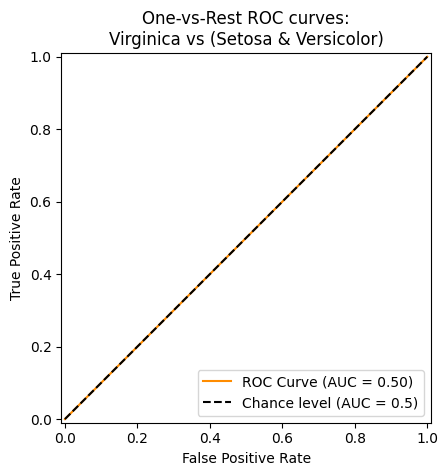

In [26]:
fpr, tpr, thresholds = roc_curve(labels, preds, pos_label=1)
display = RocCurveDisplay.from_predictions(
    labels,
    preds,
    name=f"ROC Curve",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)",
)
print(f"Thresholds: {thresholds}")

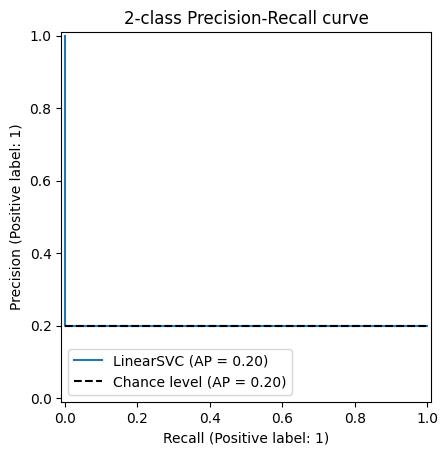

In [27]:
display = PrecisionRecallDisplay.from_predictions(
    labels, preds, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")